<a href="https://colab.research.google.com/github/Deanazor/blood-cell/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive, output
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install dependencies

In [2]:
!pip install comet_ml

!rm -rf vortex
!git clone https://github.com/nodefluxio/vortex.git
!apt-get install pciutils
!cd vortex && git checkout drop-enforce && pip install --ignore-installed --timeout=10000 ./src/development
!cd vortex && pip install --ignore-installed --timeout=10000 ./src/runtime[all]

# see https://github.com/PyTorchLightning/pytorch-lightning/issues/4533
!pip install torchtext==0.7

!mkdir -p plot

output.clear()

Restart this notebook after it finished the installation

In [16]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

output.clear()

In [17]:
! kaggle datasets download "brsdincer/cell-images-parasitized-or-not"
! unzip "cell-images-parasitized-or-not.zip" -d ""

output.clear()

In [18]:
! kaggle datasets download "iarunava/cell-images-for-detecting-malaria"
! unzip "cell-images-for-detecting-malaria.zip" -d ""

output.clear()

# Import Packages

In [3]:
import comet_ml
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger

In [4]:
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as vision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import pytorch_lightning as pl

from collections import OrderedDict

from vortex.development.utils.registry import Registry
from vortex.development.utils.metrics import METRICS, ClassificationMetrics, MetricBase
from vortex.development.networks.models import ModelBase
from vortex.development.utils.profiler.lightning import Profiler
from abc import abstractmethod

from vortex.development.exporter.onnx import ONNXExporter
from vortex.development.utils.runtime_wrapper import RuntimeWrapper

import vortex.runtime as vrt

# Classes Declaration

## Data Class

In [12]:
class BloodData(pl.LightningDataModule):
    def __init__(self, batch_size, img_size, data_folders, **kwargs):
        super().__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        if len(data_folders) < 2 or type(data_folders) != type([]):
            raise TypeError("Data folder must be a list of a minimum 2 folders amd maximum of 3")
        self.train_folder = data_folders[0]
        self.val_folder = data_folders[1]
        self.test_folder = data_folders[1] if len(data_folders) == 2 else data_folders[2]
        self._init_train_set()
        self._init_val_set()
        self._init_test_set()
    
    def _init_train_set(self):
        self.transform = transforms.Compose([
            transforms.Resize((self.img_size, self.img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        self.train_set = datasets.ImageFolder(self.train_folder,
                                                     transform=self.transform)
        self.class_names = self.train_set.classes
    
    def _init_val_set(self):
        self.val_set = datasets.ImageFolder(self.val_folder,
                                                     transform=self.transform)
    
    def _init_test_set(self):
        self.test_set = datasets.ImageFolder(self.test_folder,
                                                     transform=self.transform)

    def train_dataloader(self):
        kwargs = dict(
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
        self.train_loader = DataLoader(self.train_set, **kwargs)
        return self.train_loader
    
    def val_dataloader(self):
        kwargs = dict(
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
        self.val_loader = DataLoader(self.val_set, **kwargs)
        return self.val_loader
    
    def test_dataloader(self, batch_size):
        kwargs = dict(
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        )
        self.test_loader = DataLoader(self.test_set, **kwargs)
        return self.test_loader

## Model Class

In [13]:
class BloodModel(nn.Module):
    def __init__(self, output_num):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.25),
        )

        x = torch.randn(3,128,128).view(-1,3,128,128)
        self._to_linear = None
        self.convs(x)

        self.classifier = nn.Sequential(
            nn.Linear(self._to_linear, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(128, output_num),
            nn.LogSoftmax(dim=1)
        )
        
    def convs(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = self.classifier(x)
        return x

In [14]:
class Model(ModelBase):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.model = BloodModel(self.num_classes)
        self.criterion = nn.NLLLoss()
        self.metrics = ClassificationMetrics()
    
    def postprocess(self, x):
        x = F.softmax(x, dim=1)
        conf_label, cls_label = x.max(dim=1, keepdim=True)
        return torch.stack((cls_label.float(), conf_label), dim=1)

    def predict(self, x):
        x = self.model(x)
        return self.postprocess(x)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        prediction = self.postprocess(y_hat)
        self.metrics.update(prediction.cpu().detach(), y.cpu().detach())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        with torch.no_grad():
            y_hat = self.predict(x)
        y_hat = y_hat[:,:]
        result = self.metrics(y_hat.cpu(), y.cpu())
        self.log_dict(result)
    
    def validation_step_end(self, validation_step_outputs):
        self.log_dict(self.metrics.compute(), on_epoch=True, prog_bar=True, logger=True)
    
    def validation_epoch_end(self, *args, **kwargs):
        # we know that ClassificationMetrics' state need to be reset
        self.metrics.eval_init()

    def training_epoch_end(self, outs):
        # log epoch metric
        self.log_dict(self.metrics.compute())
        # we know that ClassificationMetrics' state need to be reset
        self.metrics.eval_init()

    def get_example_inputs(self):
        return self.sample,

    @property
    def input_names(self):
        return self._input_names

    @property
    def output_names(self):
        return self._output_names

    def on_export_start(self, exporter, dataset=None):
        batch_size = exporter.batch_size
        # not mandatory
        self.sample = next(iter(dataset.train_dataloader()))[0]
        self.sample = self.sample[:batch_size]
        self.class_names   = dataset.class_names
        self._input_names  = ['input']
        self._output_names = ['output']

    @property
    def available_metrics(self):
        return self.metrics

    @property
    def output_format(self):
        return {
            "class_label": {"indices": [0], "axis": 0},
            "class_confidence": {"indices": [1], "axis": 0}
        }

# Traning and Validation function definition

In [10]:
def train(dataset, model, epochs, export_path, comet_logger=None):
    loggers = [
        pl.loggers.TensorBoardLogger('logs/'),
    ]
    if comet_logger:
        loggers.append(comet_logger)

    trainer = pl.Trainer(
        max_epochs=epochs, gpus=-1, logger=loggers
    )

    trainer.fit(model, dataset)

    exporter = ONNXExporter(dataset=dataset)
    exporter(model, export_path)

In [11]:
def evaluate(dataset, export_path):
    profiler = Profiler(plot_dir='plot')
    trainer  = pl.Trainer(profiler=profiler)
    metric_args = dict(num_classes=2)
    runtime_device = 'cpu'
    model = RuntimeWrapper(export_path,
        profiler=profiler,
        metric_args=metric_args,
        runtime=runtime_device
    )
    batch_size = model.batch_size
    test_loader = dataset.test_dataloader(batch_size)
    trainer.test(model, test_loader)
    print(profiler.summary())
    if isinstance(profiler, Profiler):
        md = profiler.report(model=model,experiment_name='bloodcell')

        # must be str type
        dataset_info = [
            ['image_size',   str((128,128))],
            ['batch_size', str(batch_size)],
        ]
        dataset_info = md.make_table(header=['dataset args', 'value'], data=dataset_info)
        md.add_section('Dataset')
        md.write('Dataset name: bloodcell')
        md.write(dataset_info)

        output_filename = 'report.md'
        md.save(output_filename)

# Model and Parameters definition

In [8]:
path = "/content/drive/MyDrive/project_2/"
export_path = path + 'saved_model/blood_model.onnx'

In [19]:
folders_1 = ['/content/cell_images/train', '/content/cell_images/test']
dataset1 = BloodData(256, 128, folders_1)

folders_2 = ['/content/cell_images/train', '/content/cell_images/cell_images']
dataset2 = BloodData(256, 128, folders_2)

model = Model(2)

# Model training

In [ ]:
epochs=20
train(dataset1, model, epochs, export_path)

CometLogger will be initialized in online mode
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/deanazor/blood-cell-vortex/98e27ea5f29548f89cf959798411a249

COMET WARNING: Empty mapping given to log_params({}); ignoring

  | Name      | Type                  | Params
----------------------------------------------------
0 | model     | BloodModel            | 17.0 M
1 | criterion | NLLLoss               | 0     
2 | metrics   | ClassificationMetrics | 0     

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/deanazor/blood-cell-vortex/98e27ea5f29548f89cf959798411a249
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [40]             : (0.6867876052856445, 0.9745391607284546)
COMET INFO:     f1_score (macro) [40]     : (0.6861991286277771, 0.9745375514030457)
COMET INFO:     f1_score (micro) [40]     : (0.6867876052856445, 0.9745391607284546)
COMET INFO:     f1_score (weighted) [40]  : (0.6861921548843384, 0.9745378494262695)
COMET INFO:     loss [400]                : (0.03503638878464699, 0.8006765246391296)
COMET INFO:     precision (macro) [40]    : (0.68825364112854, 0.9746216535568237)
COMET INFO:     precision (micro) [40]    : (0.6867876052856445, 0.9745391607284546)
COMET INFO:     precision (weighted) [40] : (0.68826258182525

# Model evaluation

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: False
TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

GPU available but not used. Set the --gpus flag when calling the script.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.



Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9511538461538461,
 'f1_score (macro)': 0.9511536655091181,
 'f1_score (micro)': 0.9511538461538461,
 'f1_score (weighted)': 0.9511536655091181,
 'precision (macro)': 0.9511605201260374,
 'precision (micro)': 0.9511538461538461,
 'precision (weighted)': 0.9511605201260374,
 'recall (macro)': 0.9511538461538461,
 'recall (micro)': 0.9511538461538461,
 'recall (weighted)': 0.9511538461538461}
--------------------------------------------------------------------------------
on_fit_start : 3.361701965332031e-05 (mean); 3.361701965332031e-05 (median);
cache_result : 1.5637779015958484e-05 (mean); 1.1205673217773438e-05 (median);
run_test_evaluation : 53.7308509349823 (mean); 53.7308509349823 (median);
on_test_start : 0.05794167518615723 (mean); 0.05794167518615723 (median);
on_test_epoch_start : 4.076957702636719e-05 (mean); 4.076957702636719e-05 (median);
on_test_batch_st

<Figure size 432x288 with 0 Axes>

<Figure size 460.8x345.6 with 0 Axes>

<Figure size 640x480 with 0 Axes>

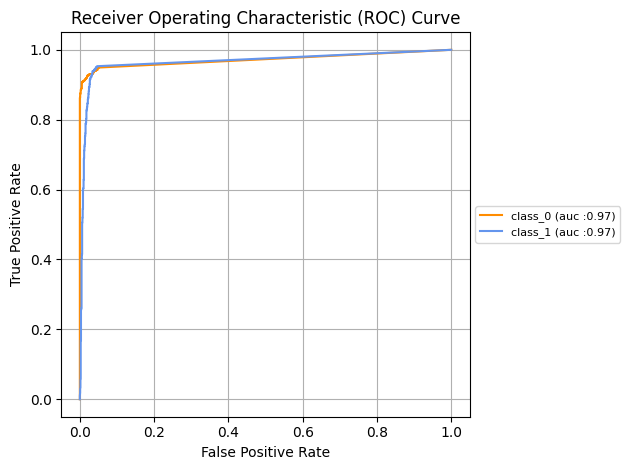

In [20]:
evaluate(dataset1, export_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.

GPU available: True, used: False
INFO:lightning:GPU available: True, used: False
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

GPU available but not used. Set the --gpus flag when calling the script.

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning:

Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.



Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.9842513970534872,
 'f1_score (macro)': 0.9842513011648576,
 'f1_score (micro)': 0.9842513970534872,
 'f1_score (weighted)': 0.9842513011648576,
 'precision (macro)': 0.9842631911284738,
 'precision (micro)': 0.9842513970534872,
 'precision (weighted)': 0.9842631911284738,
 'recall (macro)': 0.9842513970534872,
 'recall (micro)': 0.9842513970534872,
 'recall (weighted)': 0.9842513970534872}
--------------------------------------------------------------------------------
on_fit_start : 2.4080276489257812e-05 (mean); 2.4080276489257812e-05 (median);
cache_result : 1.6024153042920372e-05 (mean); 1.1205673217773438e-05 (median);
run_test_evaluation : 578.5205733776093 (mean); 578.5205733776093 (median);
on_test_start : 0.04438972473144531 (mean); 0.04438972473144531 (median);
on_test_epoch_start : 3.62396240234375e-05 (mean); 3.62396240234375e-05 (median);
on_test_batch_

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

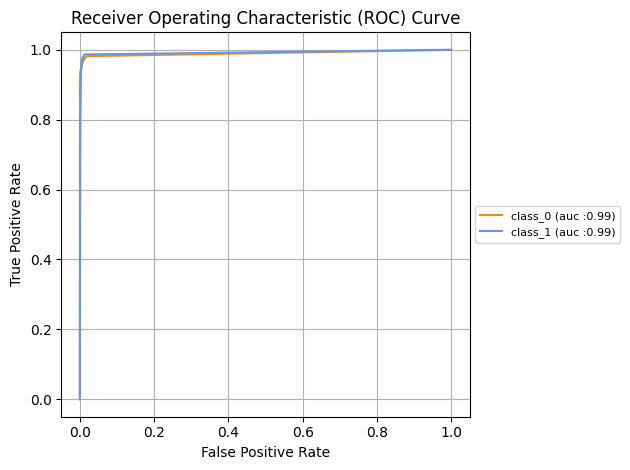

In [21]:
evaluate(dataset2, export_path)

# Inference test

In [ ]:
def normalize(img):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    img = np.array([(img[:,:,i] - mean[i]) / std[i] for i in range(len(mean))])

    return img

In [ ]:
def inference(fn):
    img = cv2.imread(fn)
    img = cv2.resize(img, (128,128), interpolation=cv2.INTER_CUBIC).astype(np.float32)/255
    img = img[:,:,::-1]
    img = normalize(img)
    img = np.expand_dims(img, 0)
    
    print(img.shape)

    runtime_device = 'cpu'

    model = vrt.create_runtime_model(model_path=export_path,
                                      runtime=runtime_device)
    print(model.class_names)
    results = model(img)
    print(results)

In [ ]:
!wget https://github.com/Deanazor/blood-cell/raw/master/coba/test_1.png
!wget https://github.com/Deanazor/blood-cell/raw/master/coba/test_2.png

output.clear()

In [ ]:
result = inference("test_1.png")
result

(1, 3, 128, 128)
{0: 'parasitized', 1: 'uninfected'}
[OrderedDict([('class_confidence', array([[0.99330306]], dtype=float32)), ('class_label', array([[1.]], dtype=float32))])]


In [ ]:
result = inference("test_2.png")
result

(1, 3, 128, 128)
{0: 'parasitized', 1: 'uninfected'}
[OrderedDict([('class_confidence', array([[1.]], dtype=float32)), ('class_label', array([[0.]], dtype=float32))])]
